Fetching market data...


HDFC.NS: No timezone found, symbol may be delisted


Successfully fetched data for 47 stocks

Identifying correlated pairs...
Found 132 correlated pairs

Testing for cointegration...


[*********************100%%**********************]  2 of 2 completed

Found 5 cointegrated pairs

Calculating hedge ratios...

Selected pair: HINDUNILVR.NS / NESTLEIND.NS


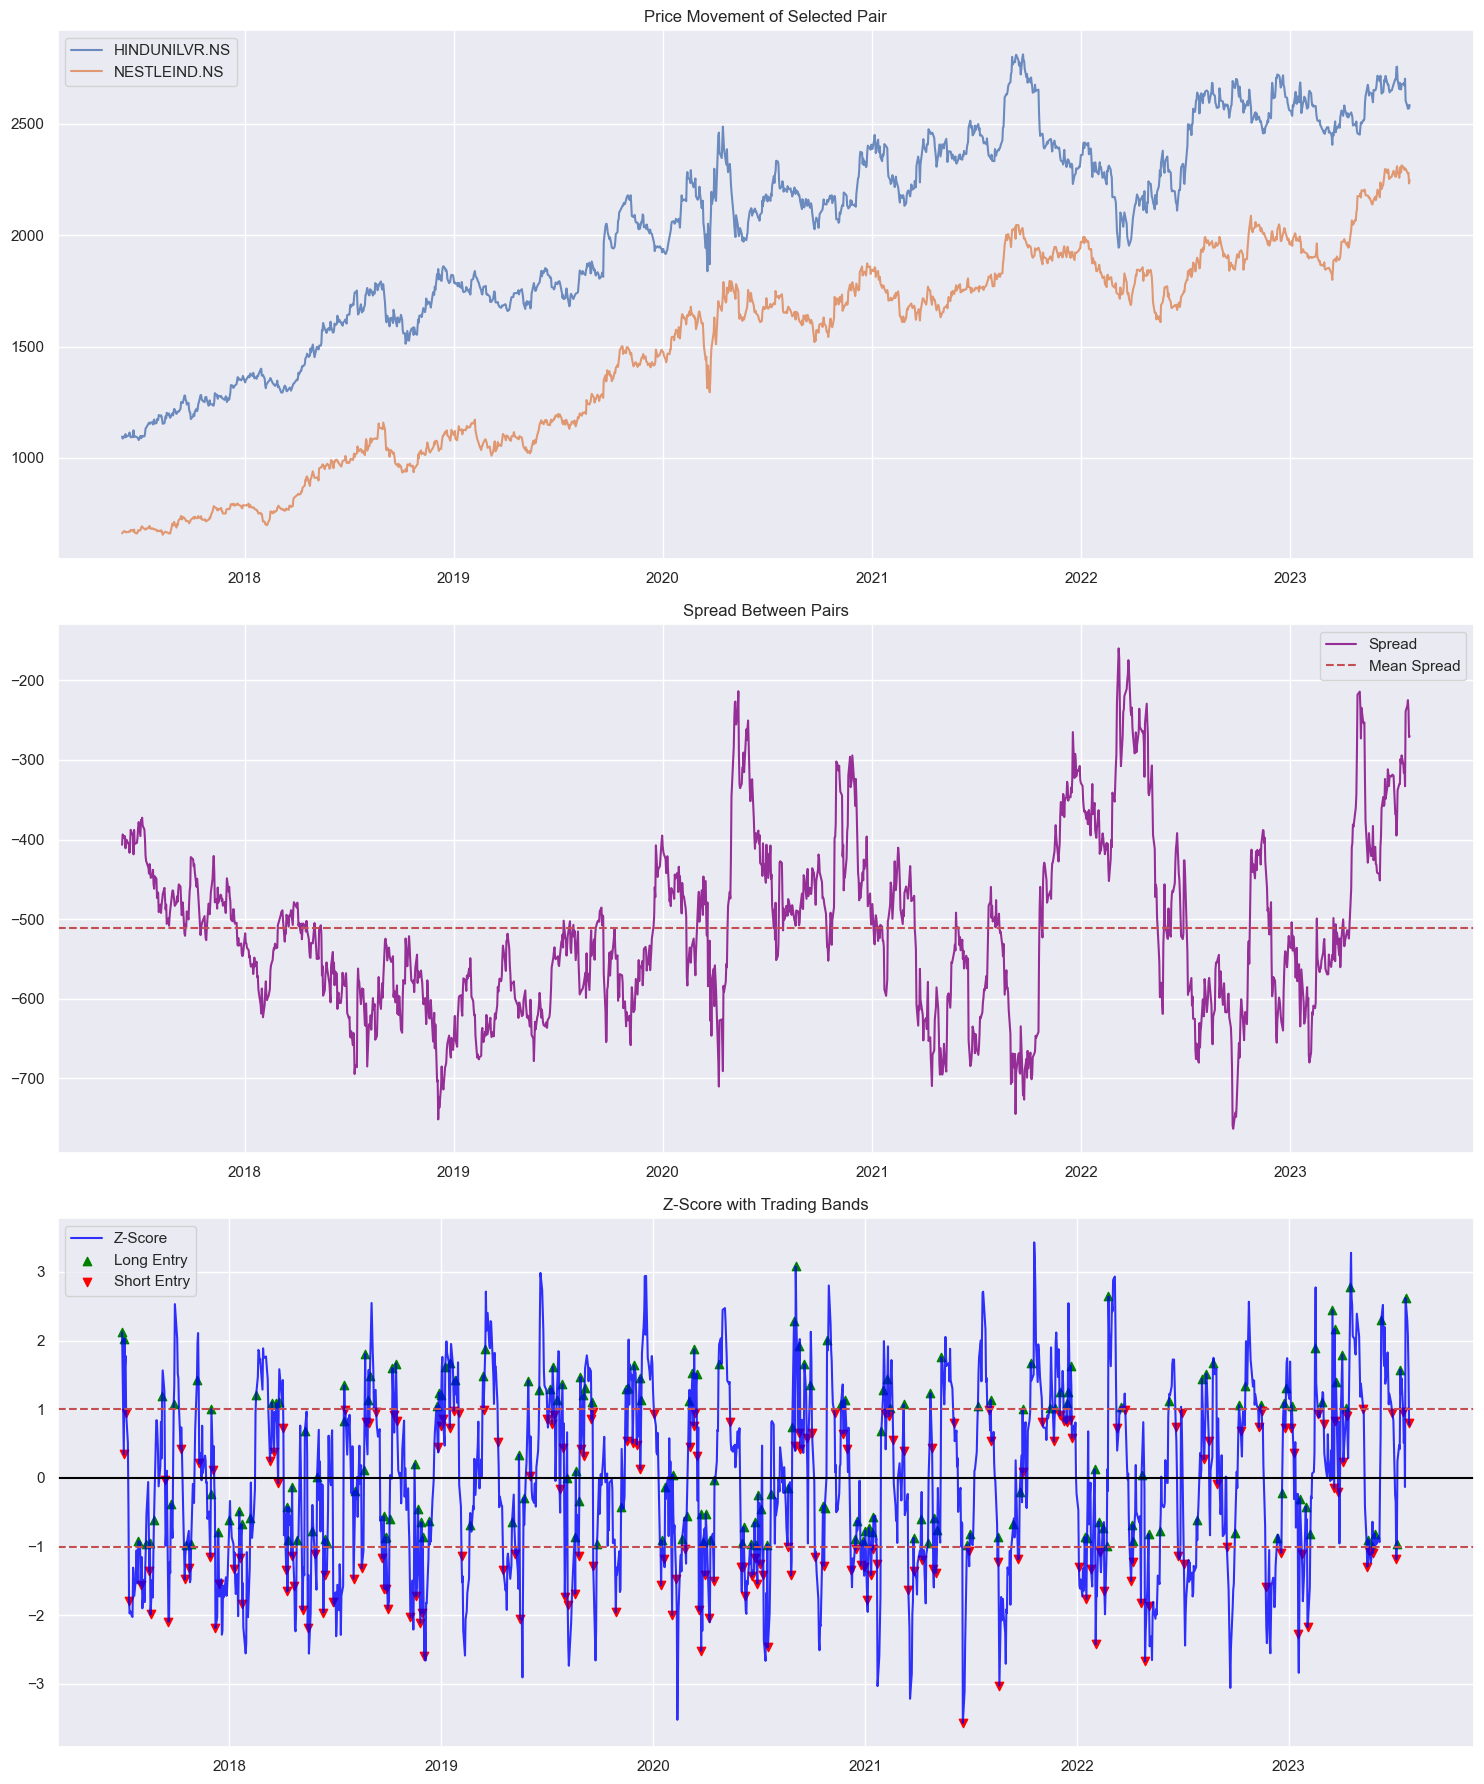


Backtesting strategy...

Calculating performance metrics...


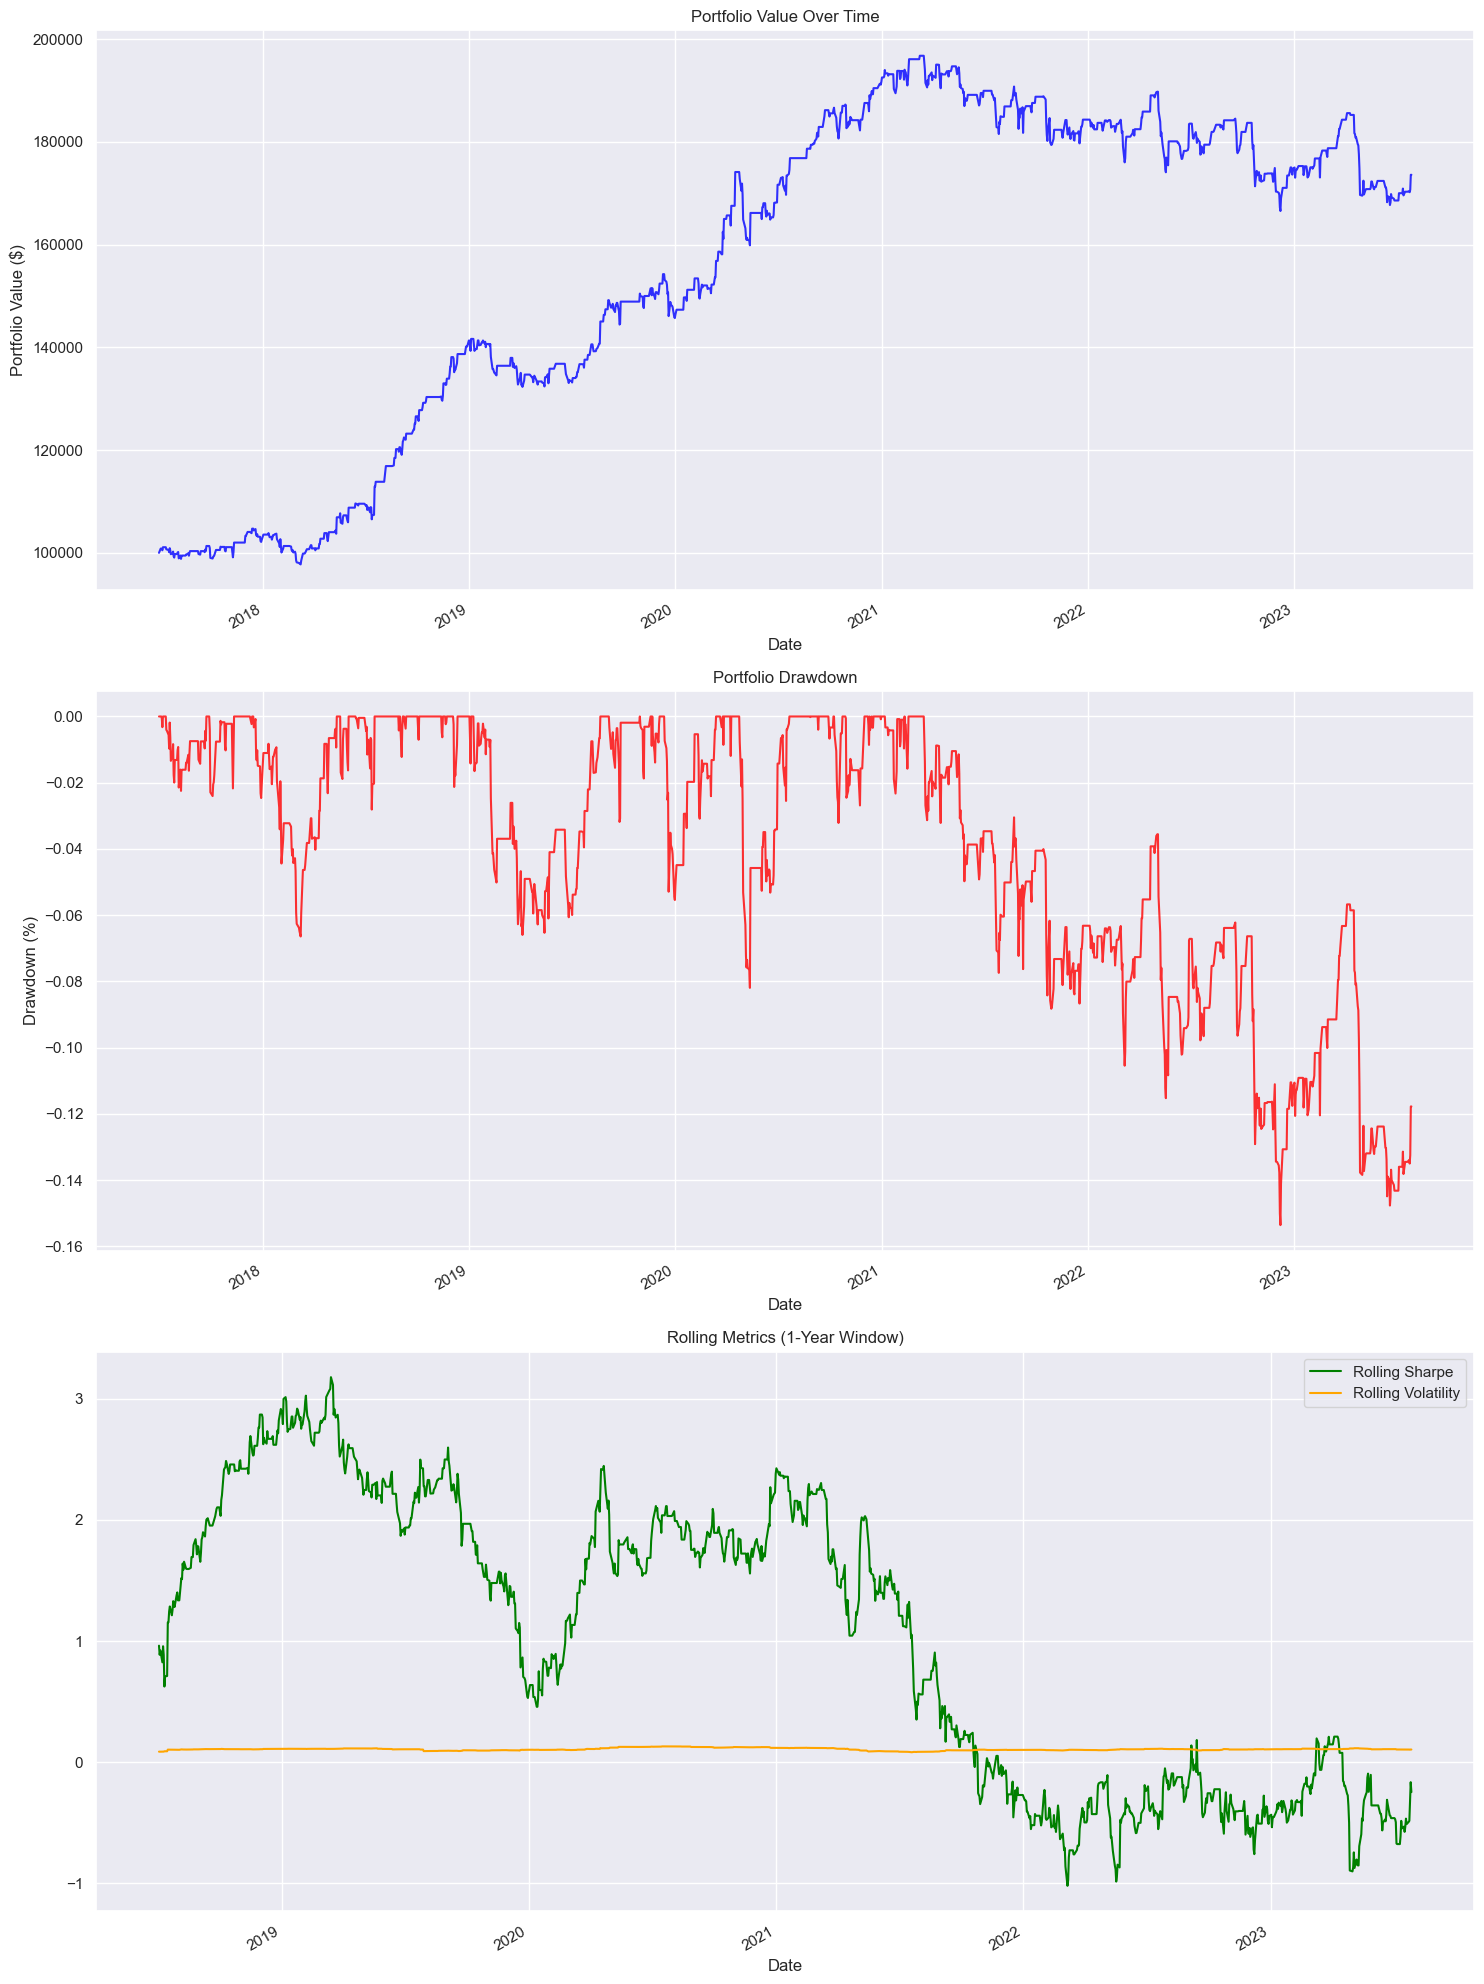


=== Pairs Trading Strategy Summary ===

Selected Pair:
Stock 1: HINDUNILVR.NS
Stock 2: NESTLEIND.NS
Hedge Ratio: 0.9743

Performance Metrics:
CAGR: 9.68%
Cumulative Return: 73.58%
Maximum Drawdown: -15.36%
Sharpe Ratio: 0.93
Sortino Ratio: 1.43
Total Trades: 400
Trades per Year: 67.02


In [4]:
# ====================================================
# Pairs Trading Strategy Implementation
# Statistical Arbitrage using Cointegration Approach
# ====================================================

# --- Data Analysis & Manipulation ---
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot settings
sns.set_theme(style="darkgrid")  
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True

# --- Financial Analysis ---
import yfinance as yf
from niftystocks import ns
import statsmodels.api as sm
import quantstats as qs
from statsmodels.tsa.stattools import coint

# --- Settings ---
import warnings
warnings.filterwarnings('ignore')

class PairsTrading:
    def __init__(self, start_date, end_date, corr_threshold=0.9, coint_threshold=0.01):
        """
        Initialize Pairs Trading Strategy
        
        Parameters:
        -----------
        start_date : str
            Start date for historical data (YYYY-MM-DD)
        end_date : str
            End date for historical data (YYYY-MM-DD)
        corr_threshold : float
            Minimum correlation coefficient to consider (default: 0.9)
        coint_threshold : float
            Maximum p-value for cointegration test (default: 0.01)
        """
        self.start_date = start_date
        self.end_date = end_date
        self.corr_threshold = corr_threshold
        self.coint_threshold = coint_threshold
        
    def fetch_market_data(self):
        """Fetch and prepare Nifty 100 stock data"""
        print("Fetching market data...")
        
        # Get all Nifty 50 tickers
        tickers = ns.get_nifty50_with_ns()
        stock_data = {}
        
        # Download historical data
        for stock in tickers:
            try:
                ticker = yf.Ticker(stock)
                stock_data[stock] = ticker.history(
                    start=self.start_date, 
                    end=self.end_date
                )['Close']
                
            except Exception as e:
                print(f"Error fetching {stock}: {str(e)}")
                continue
        
        # Create and clean dataframe
        self.stock_prices = pd.DataFrame(stock_data)
        self.stock_prices.dropna(axis=1, inplace=True)
        self.stock_prices.sort_index(inplace=True)
        
        print(f"Successfully fetched data for {self.stock_prices.shape[1]} stocks")
        return self.stock_prices
    
    def find_correlated_pairs(self):
        """Identify highly correlated pairs"""
        print("\nIdentifying correlated pairs...")
        
        # Calculate correlation matrix
        corr_matrix = self.stock_prices.corr()
        n = corr_matrix.shape[0]
        pairs = []
        
        # Find pairs above threshold
        for i in range(n):
            for j in range(i+1, n):
                correlation = corr_matrix.iloc[i, j]
                if correlation >= self.corr_threshold:
                    pairs.append({
                        'Stock1': self.stock_prices.columns[i],
                        'Stock2': self.stock_prices.columns[j],
                        'Correlation': correlation
                    })
        
        self.correlated_pairs = pd.DataFrame(pairs)
        print(f"Found {len(pairs)} correlated pairs")
        return self.correlated_pairs

    def find_cointegrated_pairs(self):
        """Test correlated pairs for cointegration"""
        print("\nTesting for cointegration...")
        
        pairs_list = []
        for _, row in self.correlated_pairs.iterrows():
            # Perform cointegration test
            stock1_prices = self.stock_prices[row['Stock1']]
            stock2_prices = self.stock_prices[row['Stock2']]
            
            coint_result = coint(stock1_prices, stock2_prices)
            p_value = coint_result[1]
            
            if p_value <= self.coint_threshold:
                pairs_list.append({
                    'Stock1': row['Stock1'],
                    'Stock2': row['Stock2'],
                    'Correlation': row['Correlation'],
                    'Cointegration_P_Value': p_value
                })
        
        self.cointegrated_pairs = pd.DataFrame(pairs_list)
        print(f"Found {len(pairs_list)} cointegrated pairs")
        return self.cointegrated_pairs

    def calculate_hedge_ratio(self):
        """Calculate hedge ratios for cointegrated pairs"""
        print("\nCalculating hedge ratios...")
        
        hedge_ratios = []
        for _, row in self.cointegrated_pairs.iterrows():
            stock1_prices = self.stock_prices[row['Stock1']]
            stock2_prices = self.stock_prices[row['Stock2']]
            
            # Calculate hedge ratio using covariance method
            covariance = np.cov(stock1_prices, stock2_prices)[0, 1]
            variance = np.var(stock1_prices)
            hedge_ratio = covariance / variance
            
            hedge_ratios.append(hedge_ratio)
        
        self.cointegrated_pairs['Hedge_Ratio'] = hedge_ratios
        self.cointegrated_pairs['HR_Distance_From_1'] = abs(self.cointegrated_pairs['Hedge_Ratio'] - 1)
        
        # Sort pairs by hedge ratio closest to 1
        self.cointegrated_pairs.sort_values('HR_Distance_From_1', inplace=True)
        return self.cointegrated_pairs

    def select_best_pair(self):
        """Select the best pair based on hedge ratio criteria"""
        self.selected_pair = {
            'Stock1': self.cointegrated_pairs.iloc[0]['Stock1'],
            'Stock2': self.cointegrated_pairs.iloc[0]['Stock2'],
            'Hedge_Ratio': self.cointegrated_pairs.iloc[0]['Hedge_Ratio']
        }
        print(f"\nSelected pair: {self.selected_pair['Stock1']} / {self.selected_pair['Stock2']}")
        return self.selected_pair

    def calculate_spread_zscore(self, lookback=21):
        """Calculate spread and z-score for the selected pair"""
        # Get prices for selected pair
        self.pair_prices = yf.download(
            [self.selected_pair['Stock1'], self.selected_pair['Stock2']], 
            start=self.start_date, 
            end=self.end_date
        )['Close']
        
        # Calculate spread
        self.spread = (-self.pair_prices[self.selected_pair['Stock1']] * 
                      self.selected_pair['Hedge_Ratio'] + 
                      self.pair_prices[self.selected_pair['Stock2']])
        
        # Calculate rolling z-score
        spread_mean = self.spread.rolling(window=lookback).mean()
        spread_std = self.spread.rolling(window=lookback).std()
        self.zscore = (self.spread - spread_mean) / spread_std
        
        return self.spread, self.zscore

    def generate_signals(self, zscore_threshold=1):
        """Generate trading signals based on z-score"""
        signals = pd.DataFrame(index=self.pair_prices.index)
        
        # Store price data
        signals[self.selected_pair['Stock1']] = self.pair_prices[self.selected_pair['Stock1']]
        signals[self.selected_pair['Stock2']] = self.pair_prices[self.selected_pair['Stock2']]
        signals['Spread'] = self.spread
        signals['ZScore'] = self.zscore
        
        # Generate signals
        signals['Signal1'] = np.select(
            [signals['ZScore'] > zscore_threshold, signals['ZScore'] < -zscore_threshold],
            [1, -1],
            default=0
        )
        
        # Calculate positions
        signals['Position1'] = signals['Signal1'].diff()
        if signals['Signal1'].iloc[0] != 0:
            signals['Position1'].iloc[0] = signals['Signal1'].iloc[0]
            
        # Generate opposite signals for second stock
        signals['Signal2'] = -signals['Signal1']
        signals['Position2'] = -signals['Position1']
        
        signals.dropna(inplace=True)
        self.signals = signals
        return signals

    def plot_pair_analysis(self):
        """Generate comprehensive pair analysis plots"""
        # Create figure with subplots
        fig, axes = plt.subplots(3, 1, figsize=(15, 18))
        
        # Plot 1: Price Movement
        axes[0].plot(self.pair_prices[self.selected_pair['Stock1']], 
                    label=self.selected_pair['Stock1'], alpha=0.8)
        axes[0].plot(self.pair_prices[self.selected_pair['Stock2']], 
                    label=self.selected_pair['Stock2'], alpha=0.8)
        axes[0].set_title('Price Movement of Selected Pair')
        axes[0].legend()
        
        # Plot 2: Spread
        axes[1].plot(self.spread, label='Spread', color='purple', alpha=0.8)
        axes[1].axhline(y=self.spread.mean(), color='r', linestyle='--', 
                       label='Mean Spread')
        axes[1].set_title('Spread Between Pairs')
        axes[1].legend()
        
        # Plot 3: Z-Score with Trading Signals
        axes[2].plot(self.zscore, label='Z-Score', color='blue', alpha=0.8)
        axes[2].axhline(y=1.0, color='r', linestyle='--')
        axes[2].axhline(y=-1.0, color='r', linestyle='--')
        axes[2].axhline(y=0, color='black', linestyle='-')
        axes[2].set_title('Z-Score with Trading Bands')
        
        # Add trading signals
        long_signals = self.signals[self.signals['Position1'] == 1].index
        short_signals = self.signals[self.signals['Position1'] == -1].index
        
        axes[2].scatter(long_signals, 
                       self.zscore.loc[long_signals], 
                       marker='^', color='green', 
                       label='Long Entry')
        axes[2].scatter(short_signals, 
                       self.zscore.loc[short_signals], 
                       marker='v', color='red', 
                       label='Short Entry')
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()

    def backtest_strategy(self, initial_capital=100000):
        """Backtest the pairs trading strategy"""
        print("\nBacktesting strategy...")
        
        # Initialize portfolio
        w1 = 0.5  # Weight for first stock
        w2 = 0.5  # Weight for second stock
        
        # Calculate number of shares for each stock
        shares1 = (w1 * initial_capital) // self.signals[self.selected_pair['Stock1']].iloc[0]
        shares2 = (w2 * initial_capital) // self.signals[self.selected_pair['Stock2']].iloc[0]
        
        # Create portfolio dataframe
        portfolio = pd.DataFrame(index=self.signals.index)
        
        # Calculate PnL for Stock 1
        portfolio['Holdings1'] = (self.signals['Position1'].cumsum() * 
                                self.signals[self.selected_pair['Stock1']] * 
                                shares1)
        portfolio['Cash1'] = (w1 * initial_capital - 
                            (self.signals['Position1'] * 
                             self.signals[self.selected_pair['Stock1']] * 
                             shares1).cumsum())
        portfolio['Total1'] = portfolio['Holdings1'] + portfolio['Cash1']
        portfolio['Returns1'] = portfolio['Total1'].pct_change()
        
        # Calculate PnL for Stock 2
        portfolio['Holdings2'] = (self.signals['Position2'].cumsum() * 
                                self.signals[self.selected_pair['Stock2']] * 
                                shares2)
        portfolio['Cash2'] = (w2 * initial_capital - 
                            (self.signals['Position2'] * 
                             self.signals[self.selected_pair['Stock2']] * 
                             shares2).cumsum())
        portfolio['Total2'] = portfolio['Holdings2'] + portfolio['Cash2']
        portfolio['Returns2'] = portfolio['Total2'].pct_change()
        
        # Calculate total portfolio value
        portfolio['Total_Value'] = portfolio['Total1'] + portfolio['Total2']
        portfolio['Total_Returns'] = portfolio['Total_Value'].pct_change()
        
        self.portfolio = portfolio
        return portfolio

    def calculate_performance_metrics(self):
        """Calculate and display key performance metrics"""
        print("\nCalculating performance metrics...")
        
        # Basic metrics
        total_days = len(self.portfolio)
        trading_days_per_year = 252
        
        # Calculate returns
        final_value = self.portfolio['Total_Value'].iloc[-1]
        initial_value = self.portfolio['Total_Value'].iloc[0]
        
        # CAGR
        years = total_days / trading_days_per_year
        cagr = (final_value / initial_value) ** (1/years) - 1
        
        # Other metrics
        cumulative_return = (final_value / initial_value) - 1
        max_drawdown = qs.stats.max_drawdown(self.portfolio['Total_Value'])
        sharpe_ratio = qs.stats.sharpe(self.portfolio['Total_Returns'])
        sortino_ratio = qs.stats.sortino(self.portfolio['Total_Returns'])
        
        # Calculate trade statistics
        total_trades = abs(self.signals['Position1']).sum()
        trades_per_year = total_trades / years
        
        # Store metrics in dictionary
        self.metrics = {
            'CAGR': cagr,
            'Cumulative Return': cumulative_return,
            'Max Drawdown': max_drawdown,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Total Trades': total_trades,
            'Trades per Year': trades_per_year
        }
        
        return self.metrics

    def plot_performance_analysis(self):
        """Generate comprehensive performance analysis plots"""
        # Create figure with subplots
        fig, axes = plt.subplots(3, 1, figsize=(15, 20))
        
        # Plot 1: Portfolio Value
        self.portfolio['Total_Value'].plot(ax=axes[0], color='blue', alpha=0.8)
        axes[0].set_title('Portfolio Value Over Time')
        axes[0].set_ylabel('Portfolio Value ($)')
        
        # Plot 2: Drawdown Analysis
        drawdown = (self.portfolio['Total_Value'] / 
                   self.portfolio['Total_Value'].cummax() - 1)
        drawdown.plot(ax=axes[1], color='red', alpha=0.8)
        axes[1].set_title('Portfolio Drawdown')
        axes[1].set_ylabel('Drawdown (%)')
        
        # Plot 3: Rolling Metrics
        window = 252  # One year rolling window
        rolling_returns = self.portfolio['Total_Returns'].rolling(window=window)
        rolling_vol = rolling_returns.std() * np.sqrt(252)
        rolling_sharpe = (rolling_returns.mean() * 252) / (rolling_returns.std() * np.sqrt(252))
        
        rolling_sharpe.plot(ax=axes[2], label='Rolling Sharpe', color='green')
        rolling_vol.plot(ax=axes[2], label='Rolling Volatility', color='orange')
        axes[2].set_title('Rolling Metrics (1-Year Window)')
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()

    def display_summary(self):
        """Display summary of strategy performance"""
        print("\n=== Pairs Trading Strategy Summary ===")
        print(f"\nSelected Pair:")
        print(f"Stock 1: {self.selected_pair['Stock1']}")
        print(f"Stock 2: {self.selected_pair['Stock2']}")
        print(f"Hedge Ratio: {self.selected_pair['Hedge_Ratio']:.4f}")
        
        print("\nPerformance Metrics:")
        print(f"CAGR: {self.metrics['CAGR']:.2%}")
        print(f"Cumulative Return: {self.metrics['Cumulative Return']:.2%}")
        print(f"Maximum Drawdown: {self.metrics['Max Drawdown']:.2%}")
        print(f"Sharpe Ratio: {self.metrics['Sharpe Ratio']:.2f}")
        print(f"Sortino Ratio: {self.metrics['Sortino Ratio']:.2f}")
        print(f"Total Trades: {self.metrics['Total Trades']:.0f}")
        print(f"Trades per Year: {self.metrics['Trades per Year']:.2f}")

    def main():
        # Initialize strategy
        strategy = PairsTrading(
            start_date="2017-06-01",
            end_date="2023-07-31",
            corr_threshold=0.9,
            coint_threshold=0.01
        )
        
        # Execute strategy steps
        strategy.fetch_market_data()
        strategy.find_correlated_pairs()
        strategy.find_cointegrated_pairs()
        strategy.calculate_hedge_ratio()
        strategy.select_best_pair()
        
        # Calculate signals
        strategy.calculate_spread_zscore()
        strategy.generate_signals()
        
        # Analyze results
        strategy.plot_pair_analysis()
        strategy.backtest_strategy()
        strategy.calculate_performance_metrics()
        strategy.plot_performance_analysis()
        strategy.display_summary()

    if __name__ == "__main__":
        main()